# Just for fun

This is just experimentation on the "Isolated Sign Language Recognition" dataset found [here](https://www.kaggle.com/competitions/asl-signs/data)

In this notebook, a data loader will be created to load the data and then some visualization will be applied. 

## Importing necessary libs

Python modules or scripts that reside in the '../src' directory need to be imported in this notebook. 
Following code will will add path to the beginning of the Python path list so that modules or scripts needed for a project which are not in the same directory as the main project file are accible.

In [1]:
import sys
sys.path.insert(0, '../src')

In [2]:
import torch
import torch.nn as nn
import os
import json
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pyarrow.parquet as pq
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from matplotlib import animation
import matplotlib.pyplot as plt
import mediapipe as mp

Following will import variables defined in a this config module. Specifically, it imports all the variables defined in config.py using the wildcard * operator.

The project related variables that will be imported are:

<b>DEVICE</b>: A string that represents the device used for training. It is either 'cuda' if a CUDA-enabled GPU is available or 'cpu' otherwise.</br>
<b>ROOT_PATH</b>: A string that represents the root directory path for the project.</br>
<b>SRC_DIR</b>: A string that represents the directory path for source files.</br>
<b>DATA_DIR</b>: A string that represents the directory path for data files.</br>
<b>MODEL_DIR</b>: A string that represents the directory path for model files.</br>
<b>CHECKPOINT_DIR</b>: A string that represents the directory path for checkpoint files.</br>
<b>RUNS_DIR</b>: A string that represents the directory path for TensorBoard log files.</br>
<b>OUT_DIR</b>: A string that represents the directory path for output files.</br>
<b>SEED</b>: An integer that represents the seed value for generating random numbers. It is set to 0 in this case.</br>

The model hyperparameters that will be imported are:
    
<b>BATCH_SIZE</b>: An integer that represents the batch size for the data loader.</br>
<b>LEARNING_RATE</b>: A float that represents the learning rate for the optimizer.</br>
<b>EPOCHS</b>: An integer that represents the number of epochs for training.</br>

The training data related variable that will be imported are:

<b>TRAIN_CSV_FILE</b>: Path of the training file `train.csv`.<br/>
<b>MAP_JSON_FILE</b>: Path of the map file `sign_to_prediction_index_map.json`.<br/>
<b>LANDMARK_FILES</b>: Root path of the landmark files `train_landmark_files`.<br/>

In [3]:
from config import *

Lets see where the data reside in config

In [4]:
DATA_DIR

'data/'

## Data Preprossing

Since the data is huge, it makes snense to preprocess it so that the data loader at training time does not need to select files at training time. 

To preprocess the data, irrelevant data items will be removed and miniman set which is needed for the processing will be kept. The data will be read from Raw data directory and processed and stored in processed data directory. This step is done once and if it is already done, will not be repeated.

The raw data and the processed data are stored in the following data directories:

<b>DATA_DIR</b>: A string that represents the directory path for data files.</br>
<b>RAW_DATA_DIR</b>: A string that represents the directory path for raw data files as downloaded from Kaggle.</br>
<b>PROCESSED_DATA_DIR</b>: A string that represents the directory path for processed data files as downloaded from Kaggle.</br>

This method `preprocess_data` preprocesses the data for easier and faster loading during training time. The data is processed and stored in `PROCESSED_DATA_DIR` if not already done. 

#### Parameters:
- `max_seq_length`: (default=`MAX_SEQUENCES`) An integer representing the maximum sequence length.

#### Functionality
If the preprocessed data already exists, the method prints "Preprocessed data found. Skipping...". 

The method first reads the metadata CSV file for training data to obtain a dictionary that maps target values to integer indices. Then, it reads the training data CSV file and generates the absolute path to locate landmark files. 

Next, the method keeps text signs and their respective indices and initializes a list to store the processed data. The data is then processed and stored in the list by iterating over each file path in the training data and reading in the parquet file for that file path. The landmark data is then processed and padded to have a length of `max_seq_length`. Finally, a dictionary with the processed data is created and added to the list.

The processed data is saved to disk using the PyTorch `torch.save` method and the saved file is printed.

In [5]:
def preprocess_data(sample=100000):
    
    if os.path.exists(os.path.join(ROOT_PATH,PROCESSED_DATA_DIR, MARKER_FILE)):
        print('Preprocessed data found. Skipping...')
        return
    
    # Check if the landmarks directory exists and create if absent
    if not os.path.exists(os.path.join(ROOT_PATH,PROCESSED_DATA_DIR,LANDMARK_FILES)):
        os.makedirs(os.path.join(ROOT_PATH,PROCESSED_DATA_DIR,LANDMARK_FILES))
                      
    # Read the Metadata CVS file for training data
    label_dict = json.load(open(os.path.join(ROOT_PATH,RAW_DATA_DIR,MAP_JSON_FILE)))

    # Read the Mapping JSON file to map target values to integer indices
    df_train = pd.read_csv(os.path.join(ROOT_PATH,RAW_DATA_DIR,TRAIN_CSV_FILE))[:sample]
                      
    # Generate Absolute path to locate landmark parquet files
    file_paths = np.array([os.path.join(ROOT_PATH, RAW_DATA_DIR, x) for x in df_train["path"].values])

    # Generate Absolute path to store landmark processed files
    participant_ids = df_train["participant_id"].values
    sequence_ids = df_train["sequence_id"].values
    processed_files = np.array([str(x)+'-'+str(y)+'.pt' for (x,y) in zip(participant_ids,sequence_ids)])

    # keep tect signs and their respective indices
    signs   = df_train["sign"].values
    targets = df_train["sign"].map(label_dict).values

    # Process the data and store it
    for i, idx in tqdm(enumerate(range(len(df_train))), total=len(df_train)):
        
        # Get the file path for the single index
        landmark_file = file_paths[idx]

        # Read in the parquet file and process the data
        landmarks = pq.read_table(landmark_file).to_pandas()

        # Read individual landmark data
        # As per dataset description 'he MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values'
        landmarks = landmarks[['frame', 'type', 'landmark_index', 'x', 'y']]

        landmarks = landmarks.pivot(index='frame', columns=['type', 'landmark_index'], values=['x', 'y'])
        landmarks.columns = [f"{col[1]}-{col[2]}_{col[0]}" for col in landmarks.columns]
        landmarks.fillna(0,inplace=True)
        landmarks.reset_index(inplace=True)

        columns = list(landmarks.columns)
        new_columns = [columns[(i+1) // 2 + (len(columns) ) // 2 * ((i+1) % 2)] for i in range(1, len(columns))]
        landmarks=landmarks[new_columns].values.tolist()
        data_size=len(landmarks)

        # Create a dictionary with the processed data
        sample = {'landmarks': landmarks, 'target': targets[idx], 'size': data_size}

        
        # Save the processed data to disk
        torch.save(sample, os.path.join(ROOT_PATH,PROCESSED_DATA_DIR,LANDMARK_FILES,processed_files[idx]))
    
    df_train["path"] = [LANDMARK_FILES+'/'+ f for f in processed_files]
    df_train.to_csv(os.path.join(ROOT_PATH,PROCESSED_DATA_DIR, TRAIN_CSV_FILE), sep=',',index=False)
    
    # Create the marker file
    with open(os.path.join(ROOT_PATH,PROCESSED_DATA_DIR, MARKER_FILE), 'w') as f:
        f.write('')
    
    print(f'Preprocessed data saved in {os.path.join(ROOT_PATH,PROCESSED_DATA_DIR, LANDMARK_FILES)}.')

In [6]:
preprocess_data(200)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.52it/s]

Preprocessed data saved in ../data/processed/train_landmark_files.


## ASL_DATSET Class

The ASL_DATSET class is a custom dataset class for loading sign Google Isolated Sign Language Recognition data in a specific format for training machine learning models.

### Class Variables

<b>sign_to_index</b>: A dictionary containing the mapping of sign names to their corresponding indices.<br/>
<b>data</b>: A Pandas DataFrame containing the data in CSV format, which includes the filename of the landmark data file, the sign name, and the video filename.<br/>
<b>landmark_dir</b>: The directory where the landmark data files are stored.<br/>

In [7]:
class ASL_DATSET(Dataset):
    def __init__(self, transform=None, max_seq_length=MAX_SEQUENCES):
        super().__init__()
        
        self.transform = transform
        
        #[TODO] get this from data
        self.max_seq_length = max_seq_length
        
        self.load_data()
        
    def load_data(self):
        
        # Load Processed data
        self.df_train = pd.read_csv(os.path.join(ROOT_PATH,PROCESSED_DATA_DIR,TRAIN_CSV_FILE))
        
        # Generate Absolute path to locate landmark files
        self.file_paths = np.array([os.path.join(ROOT_PATH,PROCESSED_DATA_DIR,x) for x in self.df_train["path"].values])
        
        # Store individual metadata lists
        # [TODO] Cleanup unnecessary files, do we need these?
        self.participant_ids = self.df_train["participant_id"].values
        self.sequence_ids = self.df_train["sequence_id"].values
        
    def __len__(self):
        return len(self.df_train)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.item()
        
        # Get the processed data for the single index
        landmark_file = self.file_paths[idx]
        
        # Read in the processed file
        landmark_file = torch.load(landmark_file)
        
        # Get the processed landmarks and target for the data
        landmarks = landmark_file['landmarks']
        target = landmark_file['target']
        size = landmark_file['size']
        
        # Pad the landmark data
        pad_len = max(0, self.max_seq_length - len(landmarks))
        landmarks = landmarks + [[0]*len(landmarks[0])] * pad_len
        
        if self.transform:
            sample = self.transform(landmarks)
        
        sample = {'landmarks': landmarks, 'target': target, 'size': size}
        
        return sample
    
    def __repr__(self):
        return f'ASL_DATSET(Participants: {len(set(self.participant_ids))}, Length: {len(self.df_train)}'

In [8]:
dataset = ASL_DATSET()
dataset

ASL_DATSET(Participants: 21, Length: 100

## Data Loader

Create a DataLoader object, which will used to load data from a dataset object in batches during training or inference. 
The DataLoader object takes three arguments:

`dataset`: the dataset object containing the data to load.<br/>
`batch_size`: the number of samples to include in each batch.<br/>
`shuffle`: a Boolean value indicating whether to shuffle the order of the samples before loading them. If True, the samples will be randomly shuffled; if False, they will be loaded in their original order.<br/>

In [9]:
## ASL Data loader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
len(dataloader)

100

Lets take a sample of data sequence and try to visualize it

In [75]:
sample = next(iter(dataloader))
frames = sample['landmarks']
target = sample['target']
size   = sample['size']

All body landmarks are present in frames, where x coordinated come first and y coordinates come later. Lets pair them together.

In [76]:
landmark_lists = np.array([[[frame[i].item(), frame[i+1].item()] for i in range(0, len(frame), 2)] for frame in frames[:size]])

## Visualize a Sample

This code uses the Mediapipe library to landmark connections for face, hand, and pose landmarks. It extracts the facial, left hand, pose, and right hand landmarks from the landmark_lists variable.

The function iterates through the pose, facial, and hand connections and plots them using Matplotlib's plot function. The connections are defined by the `FACEMESH_CONTOURS`, `POSE_CONNECTIONS`, and `HAND_CONNECTIONS` variables from the Mediapipe library.

The FuncAnimation class from Matplotlib is then used to create an animation of the plotted landmarks using the update function. The resulting animation is displayed in the Jupyter notebook using the `to_jshtml` function from the HTML class of IPython.display module.

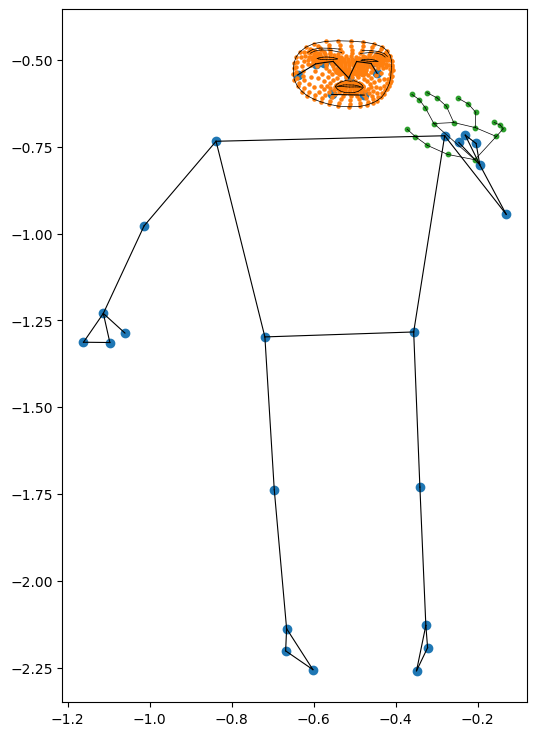

In [77]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.figure(figsize=(6,9))

# `landmark_lists` is a list containing sequence of mediapipe landmarks for face, left_hand, pose, and right_hand
face_landmarks = landmark_lists[:,:FACE_FEATURES,:]
left_hand_landmarks = landmark_lists[:,FACE_FEATURES:FACE_FEATURES+HAND_FEATURES,:]
pose_landmarks = landmark_lists[:,FACE_FEATURES+HAND_FEATURES:FACE_FEATURES+HAND_FEATURES+POSE_FEATURES,:]
right_hand_landmarks = landmark_lists[:,FACE_FEATURES+HAND_FEATURES+POSE_FEATURES:,:]

face_connections = mp.solutions.face_mesh_connections.FACEMESH_CONTOURS
pose_connections = mp.solutions.pose.POSE_CONNECTIONS
hand_connections = mp.solutions.hands.HAND_CONNECTIONS

# define a function to update the plot with the new landmarks for each frame
def update(frame):
    plt.clf()  # clear the plot
    # plot the landmarks for each body part
    plt.scatter(-pose_landmarks[frame][:, 0], -pose_landmarks[frame][:, 1])
    plt.scatter(-face_landmarks[frame][:, 0], -face_landmarks[frame][:, 1],s=5)
    if -left_hand_landmarks[frame][0, 0]!=0 and -left_hand_landmarks[frame][0, 1]!=0:
        plt.scatter(-left_hand_landmarks[frame][:, 0], -left_hand_landmarks[frame][:, 1],s=10)
    if -right_hand_landmarks[frame][0, 0]!=0 and -right_hand_landmarks[frame][0, 1]!=0:
        plt.scatter(-right_hand_landmarks[frame][:, 0], -right_hand_landmarks[frame][:, 1],s=10) 
    
    for i in pose_connections:
        plt.plot([-pose_landmarks[frame][i[0],0], -pose_landmarks[frame][i[1],0]],
                      [-pose_landmarks[frame][i[0],1], -pose_landmarks[frame][i[1],1]],
                      color='k', lw=0.8)

    for i in face_connections:
        plt.plot([-face_landmarks[frame][i[0],0], -face_landmarks[frame][i[1],0]],
                      [-face_landmarks[frame][i[0],1], -face_landmarks[frame][i[1],1]],
                      color='k', lw=0.5)

    if -left_hand_landmarks[frame][0, 0]!=0 and -left_hand_landmarks[frame][0, 1]!=0:
        for i in hand_connections:
            plt.plot([-left_hand_landmarks[frame][i[0],0], -left_hand_landmarks[frame][i[1],0]],
                      [-left_hand_landmarks[frame][i[0],1], -left_hand_landmarks[frame][i[1],1]],
                      color='k', lw=0.5)
            
    if -right_hand_landmarks[frame][0, 0]!=0 and -right_hand_landmarks[frame][0, 1]!=0:
        for i in hand_connections:
            plt.plot([-right_hand_landmarks[frame][i[0],0], -right_hand_landmarks[frame][i[1],0]],
                      [-right_hand_landmarks[frame][i[0],1], -right_hand_landmarks[frame][i[1],1]],
                      color='k', lw=0.5)

# create the animation
animation = FuncAnimation(plt.gcf(), update, frames=len(pose_landmarks), interval=50)

from IPython.display import HTML
HTML(animation.to_jshtml())

In [159]:
#landmark_lists = [[f'landmark {{x: {frame[i].item()} y: {frame[i+1].item()} }}' for i in range(0, len(frame), 2)] for frame in frames]
#pose_landmarks = text_format.Parse('\n'.join(landmark_lists[0][FACE_FEATURES+HAND_FEATURES:FACE_FEATURES+HAND_FEATURES+POSE_FEATURES]), landmark_pb2.NormalizedLandmarkList())

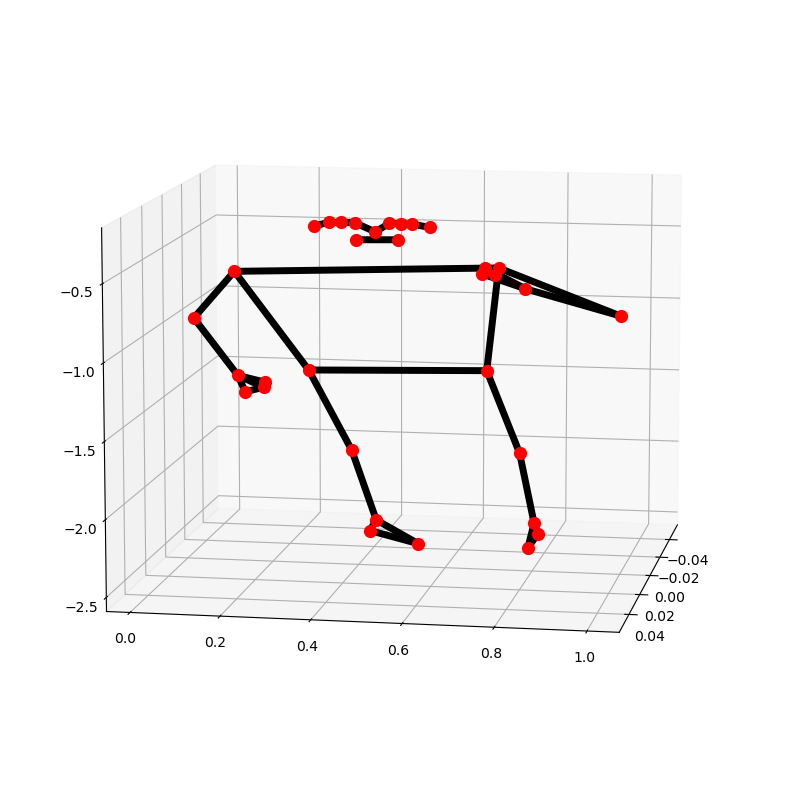

In [161]:
#mp_drawing = mp.solutions.drawing_utils 
#mp_drawing.plot_landmarks(
#        pose_landmarks, mp_pose.POSE_CONNECTIONS)

## Training

In [78]:
##